# **EDA Notebook**

In [1]:
#This cell contains the packages we will need installed. If you do not have a package, you may 
#uncomment the appropriate line

#!pip install transformers
#!pip install bert-extractive-summarizer
#!pip install tensorflow
#!pip install sentencepiece
#!pip install neuralcoref
#!pip install spacy

In [2]:
#import librarys

import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertModel
from rouge import Rouge
import matplotlib.pyplot as plt
#from summarizer.coreference_handler import CoreferenceHandler

You have imported FinRouge. FinRouge is a modified verison of rouge for summarization of finance related documents


In [3]:
#load and begin cleaning data

df = pd.read_csv("newsdf.csv")
df = df[df['text'].apply(lambda x: isinstance(x, str))]
df = df[df['title'].apply(lambda x: isinstance(x, str))]
df = df.loc[df['language'] == "english"]
df.head()

,Unnamed: 0,organizations,uuid,thread,author,url,ord_in_thread,title,locations,entities,highlightText,language,persons,text,external_links,published,crawled,highlightTitle
0,0,[],4e41266ca1707a052245161948413f057982c0b2,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Reuters Editorial,https://www.reuters.com/article/brief-au-optro...,0,BRIEF-AU Optronics to pay cash dividend of T$1...,[],"{'persons': [], 'locations': [], 'organization...",NaN,english,[],March 27(Reuters) - AU Optronics Corp :\n* Say...,"['https://twitter.com/reuters', 'https://www.y...",2018-03-27T22:14:00.000+03:00,2018-03-28T19:06:23.016+03:00,NaN
1,1,[],14baef3b7ccb2247669c395093f8080e607696cf,"{'social': {'gplus': {'shares': 0}, 'pinterest...",NaN,https://uk.reuters.com/article/uk-britain-econ...,0,British stats watchdog - stop using RPI inflat...,[],"{'persons': [{'name': 'david n', 'sentiment': ...",NaN,english,[],"March 8, 2018 / 1:35 PM / Updated an hour ago ...",[],2018-03-08T15:42:00.000+02:00,2018-03-08T16:14:31.004+02:00,NaN
2,2,[],5265614c8ca52231a35f9008ee5e4313938eb25c,"{'social': {'gplus': {'shares': 0}, 'pinterest...",NaN,https://in.reuters.com/video/2018/03/23/dropbo...,0,Dropbox shares surge in IPO,[],"{'persons': [{'name': 'fred katayama', 'sentim...",NaN,english,[],"Dropbox shares surge in IPO Saturday, March 24...",[],2018-03-23T22:23:00.000+03:00,2018-03-24T23:09:50.059+03:00,NaN
3,3,[],8c7842ac387ba659fdcf396582c5041922225324,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Reuters Editorial,https://www.reuters.com/article/us-germany-naz...,0,Bookkeeper of Auschwitz dies before starting s...,[],"{'persons': [{'name': 'oskar groening', 'senti...",NaN,english,[],BERLIN (Reuters) - The man known as the “bookk...,['http://thomsonreuters.com/en/about-us/trust-...,2018-03-13T01:05:00.000+02:00,2018-03-12T20:52:17.008+02:00,NaN
4,4,[],b58cb12cc6919413d80a00f9a38b4c22a7142411,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Alexandra Gibbs,https://www.cnbc.com/2018/03/05/us-stock-futur...,0,US stocks set for a negative open as trade war...,[],"{'persons': [{'name': 'donald trump', 'sentime...",NaN,english,[],Dow closes 336 points higher as trade-war worr...,['https://twitter.com/realDonaldTrump/status/9...,2018-03-05T13:27:00.000+02:00,2018-03-05T12:38:30.000+02:00,NaN


In [4]:
#Functions to score headlines as summaries compared with the source text

import re

rouge = Rouge()

def score_it(df):
  """This function takes in a df that already includes two columns - one labeled text and one labeled summaries.
  It outputs rouge-1, rouge-2, and rouge-l scores """
  hyps, refs = list(df['summaries']), list(df['text'])
  #rouge = Rouge()
  scores = rouge.get_scores(hyps, refs, avg = True)
  return scores

def rouge_of_headline(hyp, ref):
   """This function takes in a df that already includes two columns - one labeled text and one labeled title.It outputs rouge-1, rouge-2, and rouge-l scores """
   scores = rouge.get_scores(hyp, ref, avg = True)
   return scores

def make_headline_rouge_col(df):
  scores = []
  for i in range(len(df)):
    hyp = df['title'][i]
    ref = df['text'][i]
    score = rouge.get_scores(hyp, ref, avg = True)
    scores.append(score)
  df['headline_rouge'] = scores



In [5]:
test_df = df[:1000]
make_headline_rouge_col(test_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
test_df['headline_rouge'][0]

{'rouge-1': {'f': 0.4651162752623039, 'p': 0.9090909090909091, 'r': 0.3125},
 'rouge-2': {'f': 0.39024389875074367, 'p': 0.8, 'r': 0.25806451612903225},
 'rouge-l': {'f': 0.4651162752623039, 'p': 0.9090909090909091, 'r': 0.3125}}

In [7]:
rouge_1_scores = [test_df['headline_rouge'][i]['rouge-1']['f'] for i in range(len(test_df))]
rouge_2_scores = [test_df['headline_rouge'][i]['rouge-2']['f'] for i in range(len(test_df))]
norm_rouge_1_scores = [(test_df['headline_rouge'][i]['rouge-1']['f'])/len(test_df['title'][i].split()) for i in range(len(test_df))]
norm_rouge_2_scores = [(test_df['headline_rouge'][i]['rouge-2']['f'])/len(test_df['title'][i].split()) for i in range(len(test_df))]


In [18]:
test_df['rouge_1_scores'] = rouge_1_scores
test_df['rouge_2_scores'] = rouge_2_scores
test_df['norm_rouge_1_scores'] = norm_rouge_1_scores
test_df['norm_rouge_2_scores'] = norm_rouge_2_scores

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Text(0, 0.5, 'Rouge-1 f1 score')

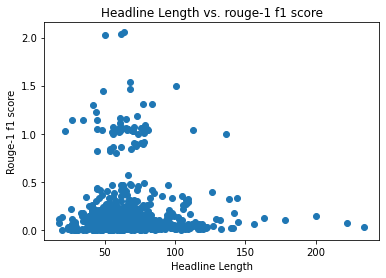

In [9]:
#Is there a relationship between rouge-1 f1 score and headline length? 
plt.scatter([len(i) for i in test_df['title']],test_df['rouge_1_scores'])
plt.title("Headline Length vs. rouge-1 f1 score")
plt.xlabel("Headline Length")
plt.ylabel("Rouge-1 f1 score")


As can be seen in the graph above, there is a relationship between headline length and f1 score. This relationship, however, is not linear, and therefore cannot be fixed through simple normalization by dividing by length. This notion in supported by Sum, et al. in the paper "How to Compare Summarizers without Target Length? Pitfalls, Solutions and Re-Examination of the Neural Summarization Literature" https://www.cis.upenn.edu/~nenkova/ComparingSummarizersWithoutTargetLength.pdf.  It is worth noting that this relationship between headline length and FinRouge f1 score is much less drastic than the relationship between headline length and regular rouge f1 score.

Text(0, 0.5, 'Normalized Rouge-1 f1 score')

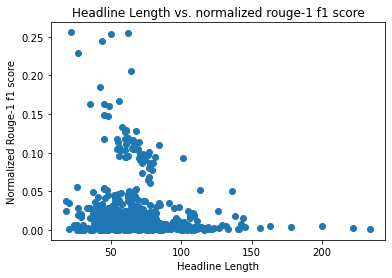

In [10]:
plt.scatter([len(i) for i in test_df['title']],norm_rouge_1_scores)
plt.title("Headline Length vs. normalized rouge-1 f1 score")
plt.xlabel("Headline Length")
plt.ylabel("Normalized Rouge-1 f1 score")

While not ideal due to the nonlinear relationship present, the above graph shows the effect of normalizing on length. It does reduce the relationship significantly, although it might not allow for accurate insights.

(array([846.,  74.,  16.,   1.,  22.,  31.,   3.,   4.,   0.,   3.]),
 array([0.        , 0.20546875, 0.4109375 , 0.61640625, 0.821875  ,
        1.02734375, 1.2328125 , 1.43828125, 1.64375   , 1.84921875,
        2.0546875 ]),
 <BarContainer object of 10 artists>)

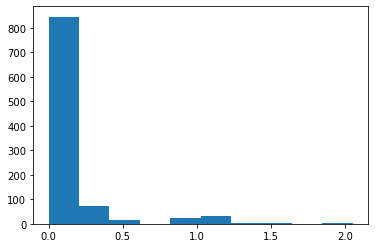

In [11]:
#plot rouge 1 f1 scores of headlines
plt.hist(rouge_1_scores)

(array([876.,  51.,   9.,   4.,  32.,  20.,   3.,   2.,   0.,   3.]),
 array([0.        , 0.20472441, 0.40944882, 0.61417323, 0.81889764,
        1.02362205, 1.22834646, 1.43307087, 1.63779528, 1.84251968,
        2.04724409]),
 <BarContainer object of 10 artists>)

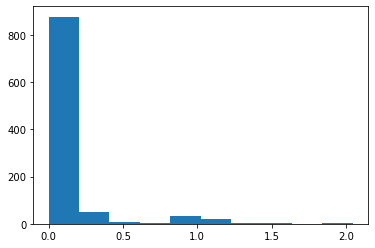

In [12]:
#plot rouge 2 f1 scores of headlines
plt.hist(rouge_2_scores)

(array([867.,  64.,  11.,  19.,  23.,   5.,   4.,   1.,   2.,   4.]),
 array([0.        , 0.0255988 , 0.0511976 , 0.07679641, 0.10239521,
        0.12799401, 0.15359281, 0.17919162, 0.20479042, 0.23038922,
        0.25598802]),
 <BarContainer object of 10 artists>)

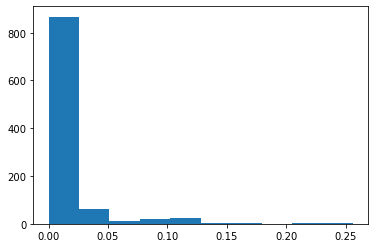

In [13]:
plt.hist(norm_rouge_1_scores)

(array([888.,  49.,   6.,  20.,  21.,   6.,   3.,   1.,   3.,   3.]),
 array([0.        , 0.02512215, 0.0502443 , 0.07536645, 0.1004886 ,
        0.12561075, 0.1507329 , 0.17585505, 0.2009772 , 0.22609935,
        0.2512215 ]),
 <BarContainer object of 10 artists>)

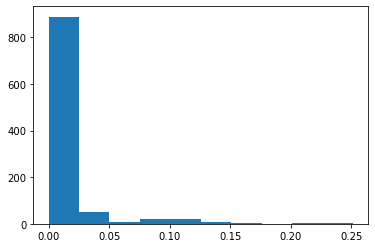

In [14]:
plt.hist(norm_rouge_2_scores)

# **Clickbait**

Upon analysing the highest and lowest FinRouge-1 f1 scoring headlines, it is seen that there is a much higher prevalence of clickbait-style headlines among low rouge-1 f1 scored articles. It is hypothesized that this effect would be more pronounced given proper normalization of the data.

Although the printouts are long, they are worth looking through.  One significant result is that even though normalizing by headline length is conceptually problematic, it does appear to make the FinRouge f1 score more effective. While headlines with un-normalized scores are noticably different on both extremes, with more clickbait and low quality headlines among the lower scores, the effects are much more pronounced with the headlines normalized by length. Low scoring length normalized FinRouge-1 f1 scores, for example, are filled with click bait and poor quality, while high scores are very high in quality with no clickbait seen.

In [19]:
#50 articles in sample with highest FinRouge-1-F1 score
pd.set_option('display.max_colwidth', None)
test_df[['title','rouge_1_scores']].sort_values(by = "rouge_1_scores", ascending=False).head(50)

,title,rouge_1_scores
72,Positive earnings give European shares a boost but SocGen weighs,2.054687
496,"Brazil telecom Oi reports preliminary results, delays earnings",2.036630
973,U.S. steel shares crawl back from financial crisis,2.025974
817,Amazon just the latest tech stock to join the market's fallen angels,1.533333
155,BRIEF-Tianjin Chase Sun Pharmaceutical to pay cash dividend of 0.2 yuan (pre-tax) for every 10 shares,1.500000
834,Fmr. Bethlehem Steel CEO: Must be a remedy for threat to our economy,1.464286
789,Applied BioCode to issue new shares worth $15 mln,1.444444
491,BRIEF-Maoye Communication and Network says individual shareholder to add 7 pct stake,1.313725
65,"BRIEF-GameWith to acquire 1,250 shares of Game Server Services for 25 mln yen",1.310345
604,Tariffs to create ripple across US economy,1.297872


In [20]:
#50 articles in sample with lowest FinRouge-1-F1 score
pd.set_option('display.max_colwidth', None)
test_df[['title','rouge_1_scores']].sort_values(by = "rouge_1_scores", ascending=True).head(50)

,title,rouge_1_scores
910,BRIEF-Fitch Affirms Malaysia At 'A-'; Outlook Stable‍​,0.000000
352,ゴールドマン、「あなたの町の銀行」になれるか - WSJ,0.000000
905,BRIEF-Platige Image Signs Framework Agreement With Ubisoft Entertainment Sweden,0.000000
717,"Court-Ordered Rehab Is Costly, Ineffective",0.000000
794,BRIEF-Kucukcalik Tekstil Transfers Total Of 7.2 Mln Shares In Luks Kadife To Yasar And Yilmaz Kucukcalik,0.000000
985,Ethiopia Completes Historic Leadership Change,0.000000
422,BRIEF-Ritter Pharma Board Approves 1-For-10 Reverse Stock Split,0.000000
862,BRIEF-Saudi's Alinma Tokio Marine Renews Insurance Contract With Aljomaih Group,0.000000
908,What If Off-Duty Employees Unplugged?,0.000000
349,Wednesday Morning Briefing,0.000000


In [24]:
#50 articles in sample with highest normalized FinRouge-1-F1 score
pd.set_option('display.max_colwidth', None)
test_df[['title','norm_rouge_1_scores']].sort_values(by = "norm_rouge_1_scores", ascending=False).head(50)

,title,norm_rouge_1_scores
275,Natera reports 4Q loss,0.255988
496,"Brazil telecom Oi reports preliminary results, delays earnings",0.254579
973,U.S. steel shares crawl back from financial crisis,0.253247
264,General Biologicals appoints general manager,0.244444
2,Dropbox shares surge in IPO,0.229412
72,Positive earnings give European shares a boost but SocGen weighs,0.205469
604,Tariffs to create ripple across US economy,0.185410
730,BRIEF-Broadcom Says Qualcomm delayed shareholder meeting,0.166667
477,Trump says stock market is 'way up',0.163690
463,Facebook shares tumble as FTC announces probe,0.163265


In [23]:
#50 articles in sample with lowest normalized FinRouge-1-F1 score
pd.set_option('display.max_colwidth', None)
test_df[['title','norm_rouge_1_scores']].sort_values(by = "norm_rouge_1_scores", ascending=True).head(50)

,title,norm_rouge_1_scores
908,What If Off-Duty Employees Unplugged?,0.000000
673,Mr. Lighthizer’s Managed Trade,0.000000
280,テスラ、「モデルS」12万3000台をリコール - WSJ,0.000000
359,BRIEF-Belle Corp Confirms Information In Manila Standard.Net News Article ‍​,0.000000
681,BRIEF-Sotheby's Extends Share Ownership To Employees Around The World,0.000000
260,What’s News: Business & Finance,0.000000
352,ゴールドマン、「あなたの町の銀行」になれるか - WSJ,0.000000
947,BRIEF-Western Securities' Long-Term Credit Rating On Watch List,0.000000
974,BRIEF-Ratos announces changes to management team,0.000000
422,BRIEF-Ritter Pharma Board Approves 1-For-10 Reverse Stock Split,0.000000
